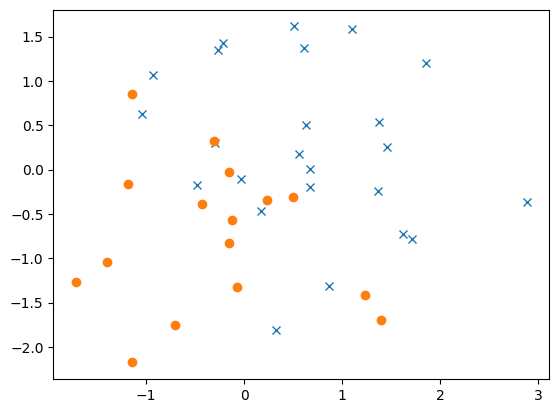

In [166]:
# requirement
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

# prepare dataset
np.random.seed(3846)
n = 40
omega = np.random.randn()
noise = 0.8 * np.random.randn(n)

x = np.random.randn(n, 2) + 0
y = 2 * (omega * x[:,0] + x[:,1] + noise > 0) - 1

plt.plot(np.extract(y>0,x[:,0]),np.extract(y>0,x[:,1]), 'x')
plt.plot(np.extract(y<0,x[:,0]),np.extract(y<0,x[:,1]), 'o')

# dataset 6
d_d6 = 200
n_d6 = 180

# we consider 5 groups where each group has 40 attributes
groupSize = 5
attrSize = 40
g_d6 = np.arange(groupSize*attrSize).reshape(groupSize,-1)

x_d6 = np.random.randn(n_d6, d_d6)
noise_d6 = 0.5

# we consider feature in group 1 and group 2 is activated.
w_d6 = np.vstack([20 * np.random.randn(80, 1),
                 np.zeros((120, 1)),
                 5 * np.random.rand()])
x_d6_tilde = np.hstack([x_d6, np.ones((n_d6, 1))])
y_d6 = np.dot(x_d6_tilde, w_d6) + noise_d6 * np.random.randn(n_d6, 1)

# Problem 2

In [167]:
# condition
A_1 = np.array([[  3, 0.5],
              [0.5,   1]])
mu_1 = np.array([[1],
               [2]])

In [168]:
# Proximal gradient method implementation
def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def proximal_gradient_lasso(A, mu, lam, max_iter=1000, tol=1e-8):
    L = np.max(np.linalg.eigvals(A))
    eta = 1.0 / L

    # Initialize w
    w = np.zeros_like(mu)

    # Store objective values and iterations
    obj_values = []

    def objective(w):
        diff = w - mu
        return 0.5 * np.dot(diff.T, np.dot(A, diff))[0,0] + lam * np.sum(np.abs(w))

    for t in range(max_iter):
        # Compute gradient of smooth part: A(w - mu)
        grad = np.dot(A, w - mu)

        # Gradient step
        w_temp = w - eta * grad

        # Proximal step (soft thresholding)
        w_new = soft_threshold(w_temp, eta * lam)

        # Compute objective value
        obj_val = objective(w_new)
        obj_values.append(obj_val)

        # Check convergence
        if t > 0 and np.abs(obj_values[-2] - obj_values[-1]) < tol:
            break

        w = w_new.copy()

    return w, obj_values

# Verify with CVX for comparison
def solve_lasso_cvx(A, mu, lam):
    w = cv.Variable((len(mu), 1))
    diff = w - mu
    objective = cv.Minimize(0.5 * cv.quad_form(diff, A) + lam * cv.norm(w, 1))
    problem = cv.Problem(objective)
    problem.solve()
    return w.value, problem.value

In [169]:
# Problem 1: Visualize optimal parameter w_hat for different lambda values

w_hat_lam = []
lams = np.arange(0, 10, 0.01)
obj_values_all = []

for i, lam in enumerate(lams):
    w_hat, obj_vals = proximal_gradient_lasso(A_1, mu_1, lam, max_iter=1000)
    w_hat_lam.append(w_hat.flatten())
    obj_values_all.append(obj_vals)

w_hat_lam = np.array(w_hat_lam)

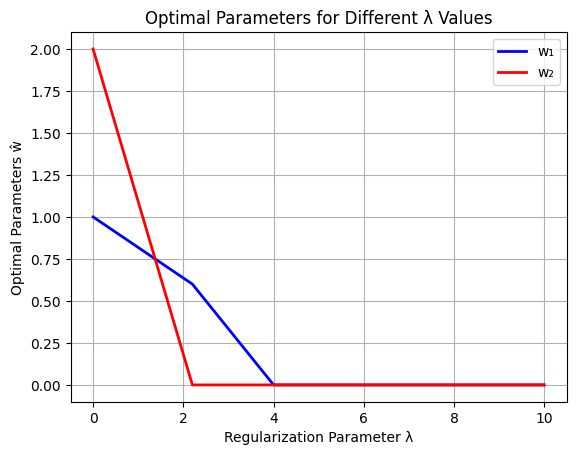

In [170]:
# Plot optimal parameters for different λ values

plt.plot(lams, w_hat_lam[:, 0], 'b-', label='w₁', linewidth=2)
plt.plot(lams, w_hat_lam[:, 1], 'r-', label='w₂', linewidth=2)
plt.xlabel('Regularization Parameter λ')
plt.ylabel('Optimal Parameters ŵ')
plt.title('Optimal Parameters for Different λ Values')
plt.legend()
plt.grid(True)
plt.show()

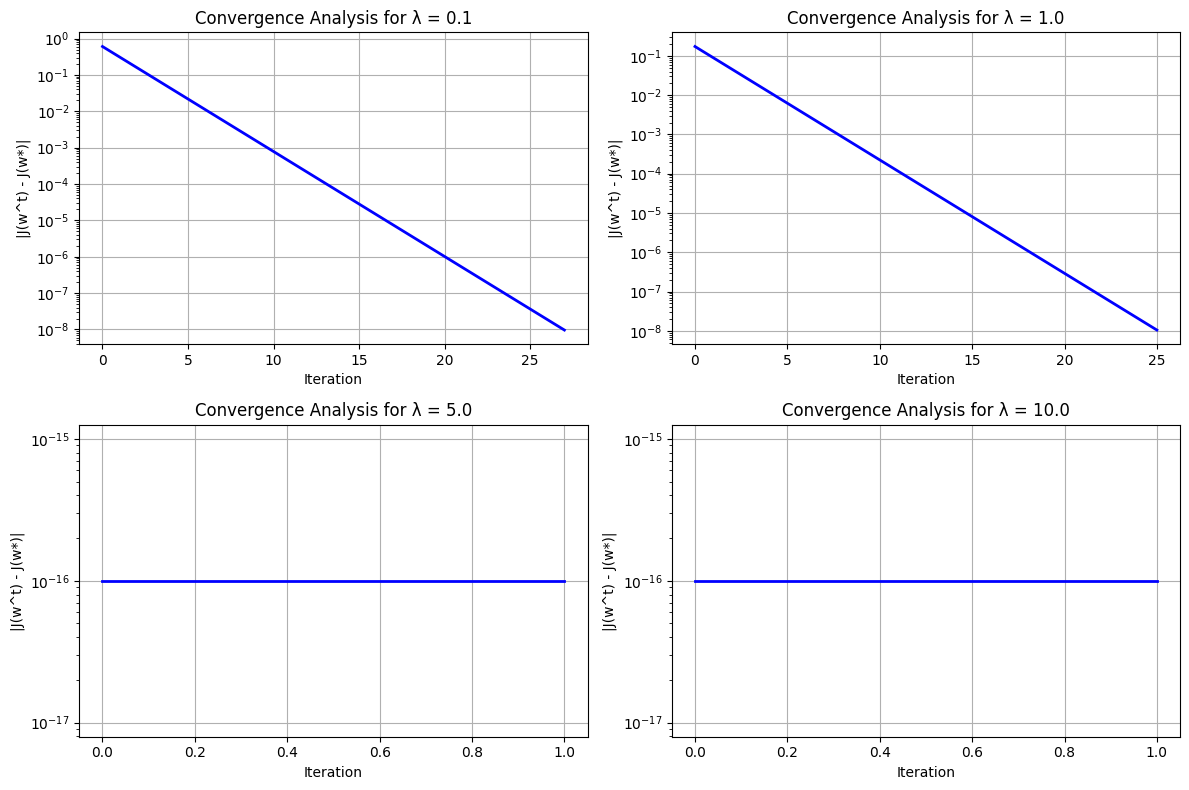

In [171]:
# Show convergence for specific lambda values

# Test convergence for a few lambda values
test_lambdas = [0.1, 1.0, 5.0, 10.0]
plt.figure(figsize=(12, 8))

for i, lam in enumerate(test_lambdas):
    plt.subplot(2, 2, i+1)

    # Run PG method and get convergence history
    w_hat, obj_vals = proximal_gradient_lasso(A_1, mu_1, lam, max_iter=1000)

    # Compute optimal value using CVX
    w_opt_cvx, opt_val_cvx = solve_lasso_cvx(A_1, mu_1, lam)

    # Compute |J(w^t) - J(w*)|
    diff_obj = np.abs(np.array(obj_vals) - opt_val_cvx)

    # Ensure positive values for log scale by adding small epsilon
    diff_obj = np.maximum(diff_obj, 1e-16)

    plt.semilogy(diff_obj, 'b-', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('|J(w^t) - J(w*)|')
    plt.title(f'Convergence Analysis for λ = {lam}')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [172]:
# Problem 2: Compare PG with AdaGrad

def adagrad_lasso(A, mu, lam, max_iter=1000, tol=1e-8, epsilon=1e-8):
    # Initialize
    w = np.zeros_like(mu)
    G = np.zeros_like(mu)

    obj_values = []

    def objective(w):
        diff = w - mu
        return 0.5 * np.dot(diff.T, np.dot(A, diff))[0,0] + lam * np.sum(np.abs(w))

    for t in range(max_iter):
        # Compute gradient of smooth part
        grad = np.dot(A, w - mu)

        # Update accumulated gradients
        G += grad * grad

        # AdaGrad learning rate
        eta_ada = 1.0 / (np.sqrt(G + epsilon))

        # Gradient step with adaptive learning rate
        w_temp = w - eta_ada * grad

        # Proximal step
        w_new = soft_threshold(w_temp, eta_ada * lam)

        # Compute objective value
        obj_val = objective(w_new)
        obj_values.append(obj_val)

        # Check convergence
        if t > 0 and np.abs(obj_values[-2] - obj_values[-1]) < tol:
            break

        w = w_new.copy()

    return w, obj_values

# problem setup
A_2 = np.array([[300.0, 0.5],
                  [0.5, 10.0]])
mu_2 = np.array([[1.0],
                   [2.0]])
lam_test = 1.0

# Run both methods
w_pg, obj_vals_pg = proximal_gradient_lasso(A_2, mu_2, lam_test, max_iter=2000)
w_ada, obj_vals_ada = adagrad_lasso(A_2, mu_2, lam_test, max_iter=2000)

# Get optimal value using CVX
w_opt, opt_val = solve_lasso_cvx(A_2, mu_2, lam_test)

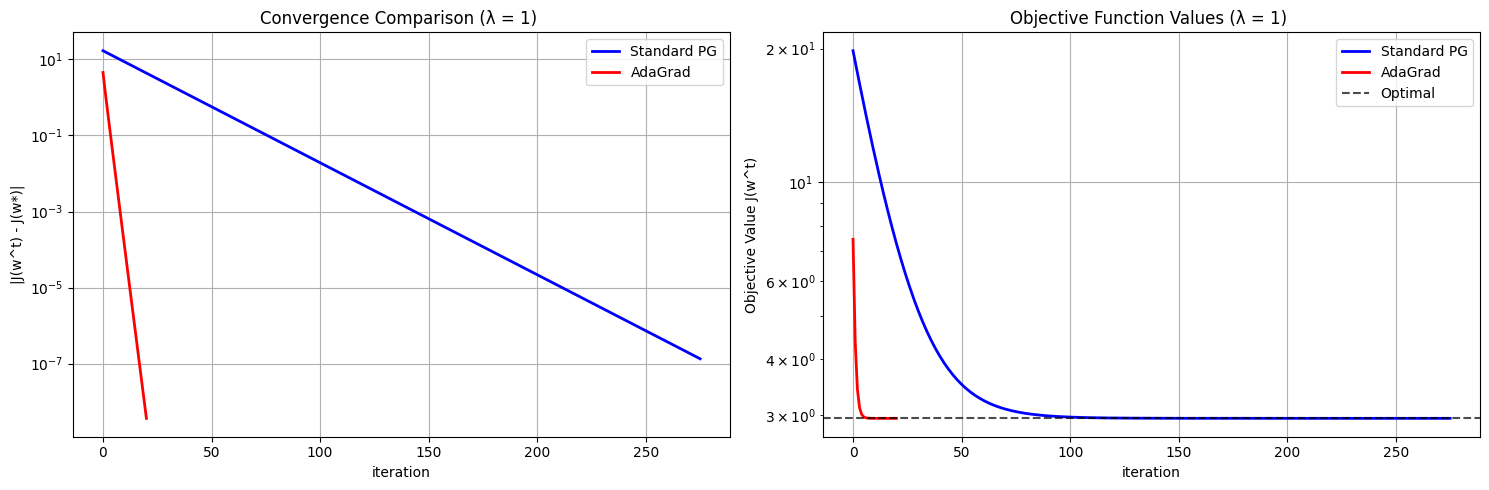

In [173]:
# Plot comparison of convergence rates
plt.figure(figsize=(15, 5))

# Plot 1: Full convergence curves
plt.subplot(1, 2, 1)
obj_gaps_pg = np.abs(np.array(obj_vals_pg) - opt_val)
obj_gaps_ada = np.abs(np.array(obj_vals_ada) - opt_val)

plt.semilogy(obj_gaps_pg, 'b-', linewidth=2, label='Standard PG')
plt.semilogy(obj_gaps_ada, 'r-', linewidth=2, label='AdaGrad')
plt.xlabel('iteration')
plt.ylabel('|J(w^t) - J(w*)|')
plt.title('Convergence Comparison (λ = 1) ')
plt.legend()
plt.grid(True)

# Plot 2: Objective function values
plt.subplot(1, 2, 2)
plt.semilogy(obj_vals_pg, 'b-', linewidth=2, label='Standard PG')
plt.semilogy(obj_vals_ada, 'r-', linewidth=2, label='AdaGrad')
plt.axhline(y=opt_val, color='k', linestyle='--', alpha=0.7, label='Optimal')
plt.xlabel('iteration')
plt.ylabel('Objective Value J(w^t)')
plt.ylabel('Objective Value J(w^t)')
plt.title('Objective Function Values (λ = 1) ')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [174]:
import cvxpy as cv
import matplotlib.pyplot as plt

def mldivide(A, b):
  piA = np.linalg.pinv(A)
  x = np.dot(piA, b)
  return x

# run the cell which preparing dataset 6 before run this cell
y = y_d6
x_tilde = x_d6_tilde
w = w_d6
noise = noise_d6
n = n_d6
d = d_d6
g = g_d6

lam = 1.0
wridge = mldivide(np.dot(x_tilde.T, x_tilde) + lam * np.eye(d+1), 
                  np.dot(x_tilde.T, y))

# cvx
west = cv.Variable((d+1,1))
obj_fn = \
  0.5 / n * cv.quad_form(x_tilde * west - y, np.eye(x_tilde.shape[0])) + \
  lam * (cv.norm(west[g[0]], 2.0) + \
         cv.norm(west[g[1]], 2.0) + \
         cv.norm(west[g[2]], 2.0) + \
         cv.norm(west[g[3]], 2.0) + \
         cv.norm(west[g[4]], 2.0) )
  
objective = cv.Minimize(obj_fn)
constraints = []

prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT)

# test
x_test = np.random.randn(n, d)
x_test_tilde = np.hstack([x_test, np.ones((n, 1))])
y_test = np.dot(x_test_tilde, w) + noise * np.random.randn(n, 1)
y_pred = np.dot(x_test_tilde, west.value)
print(np.mean((y_pred - y_test)**2))

/Users/kitamurakaname/Library/Python/3.11/lib/python/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 12 times so far.

  warnings.warn(msg, UserWarning)


15.62378595437815


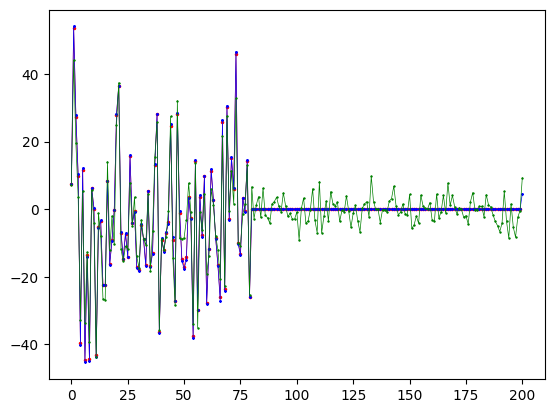

In [175]:
plt.plot(west.value[0:d], 'r-o', markersize=1.5, linewidth=0.5)
plt.plot(w, 'b-*', markersize=1.5, linewidth=0.5)
plt.plot(wridge, 'g-+', markersize=1.5, linewidth=0.5)

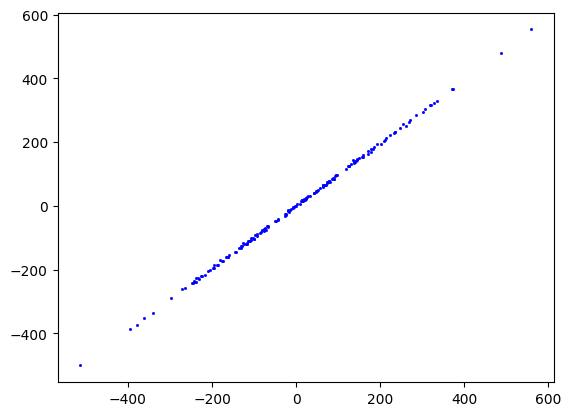

In [176]:
plt.plot(y_test, y_pred, 'bs', markersize=1)

In [177]:
print('carinality of w hat: %d'%sum(np.abs(west.value) < 0.01))
print('carinality of w ground truth: %d'%sum(np.abs(w) < 0.01))

carinality of w hat: 120
carinality of w ground truth: 120


/var/folders/ts/p2qw0ys97xvgs7fz9r2ylxth0000gn/T/ipykernel_39368/166065841.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('carinality of w hat: %d'%sum(np.abs(west.value) < 0.01))
/var/folders/ts/p2qw0ys97xvgs7fz9r2ylxth0000gn/T/ipykernel_39368/166065841.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('carinality of w ground truth: %d'%sum(np.abs(w) < 0.01))
